In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

2023-10-21 19:53:07.218434: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-21 19:53:07.218503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-21 19:53:07.218526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 19:53:07.225598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3*1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-21 19:53:08.897782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 19:53:08.901696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 19:53:08.901745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 19:53:08.903864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 19:53:08.903911: I tensorflow/compile

In [3]:
train_images_path ="./images/train/"
test_images_path ="./images/validation/"

In [4]:
labels = ["angry","disgust","fear","happy","neutral","sad","surprise"]

In [5]:
def loadImages(folderPath):
    images = []
    directories = set()
    labels = []
    for file in os.listdir(folderPath):
        if os.path.isdir(os.path.join(folderPath,file)):
            directories.add(file)
        else:
            label = os.path.basename(folderPath)
            labels.append(label)
            if file.endswith('jpg') == False:
                continue
            img = plt.imread(os.path.join(folderPath,file))
            if img is not None:
                images.append(img)
                
    for dir in directories:
        retImages,retLabels =  loadImages(os.path.join(folderPath,dir))
        if retImages is not None and len(retImages) > 0:
            images += retImages
            labels += retLabels
    
    print("Loaded ",len(images)," images from ",folderPath)
    return images, labels

In [6]:
train_images,train_labels = loadImages(train_images_path)
test_images,test_labels = loadImages(test_images_path)

Loaded  3993  images from  ./images/train/angry
Loaded  4982  images from  ./images/train/neutral
Loaded  4103  images from  ./images/train/fear
Loaded  436  images from  ./images/train/disgust
Loaded  7164  images from  ./images/train/happy
Loaded  3205  images from  ./images/train/surprise
Loaded  4938  images from  ./images/train/sad
Loaded  28821  images from  ./images/train/
Loaded  960  images from  ./images/validation/angry
Loaded  1216  images from  ./images/validation/neutral
Loaded  1018  images from  ./images/validation/fear
Loaded  111  images from  ./images/validation/disgust
Loaded  1825  images from  ./images/validation/happy
Loaded  797  images from  ./images/validation/surprise
Loaded  1139  images from  ./images/validation/sad
Loaded  7066  images from  ./images/validation/


In [7]:
print("Number of train images loaded: ",len(train_images))
print("Number of train labels loaded: ",len(train_labels))
print("Number of test images loaded: ",len(test_images))
print("Number of test labels loaded: ",len(test_labels))

Number of train images loaded:  28821
Number of train labels loaded:  28821
Number of test images loaded:  7066
Number of test labels loaded:  7066


In [8]:
def getLabelRanges(labelData,labels):
    labelRanges = []
    for label in labels:
        labelRanges.append([i for i, x in enumerate(labelData) if x == label])
    return labelRanges
    

In [9]:
label_ranges_train = getLabelRanges(train_labels,labels)
label_ranges_test = getLabelRanges(test_labels,labels)

per_label_range_train = []
for sets in label_ranges_train:
    per_label_range_train.append((min(sets),max(sets),train_labels[sets[0]],len(sets)))
    
per_label_range_train

[(0, 3992, 'angry', 3993),
 (13078, 13513, 'disgust', 436),
 (8975, 13077, 'fear', 4103),
 (13514, 20677, 'happy', 7164),
 (3993, 8974, 'neutral', 4982),
 (23883, 28820, 'sad', 4938),
 (20678, 23882, 'surprise', 3205)]

# Train Class Distribution Plotting

<BarContainer object of 7 artists>

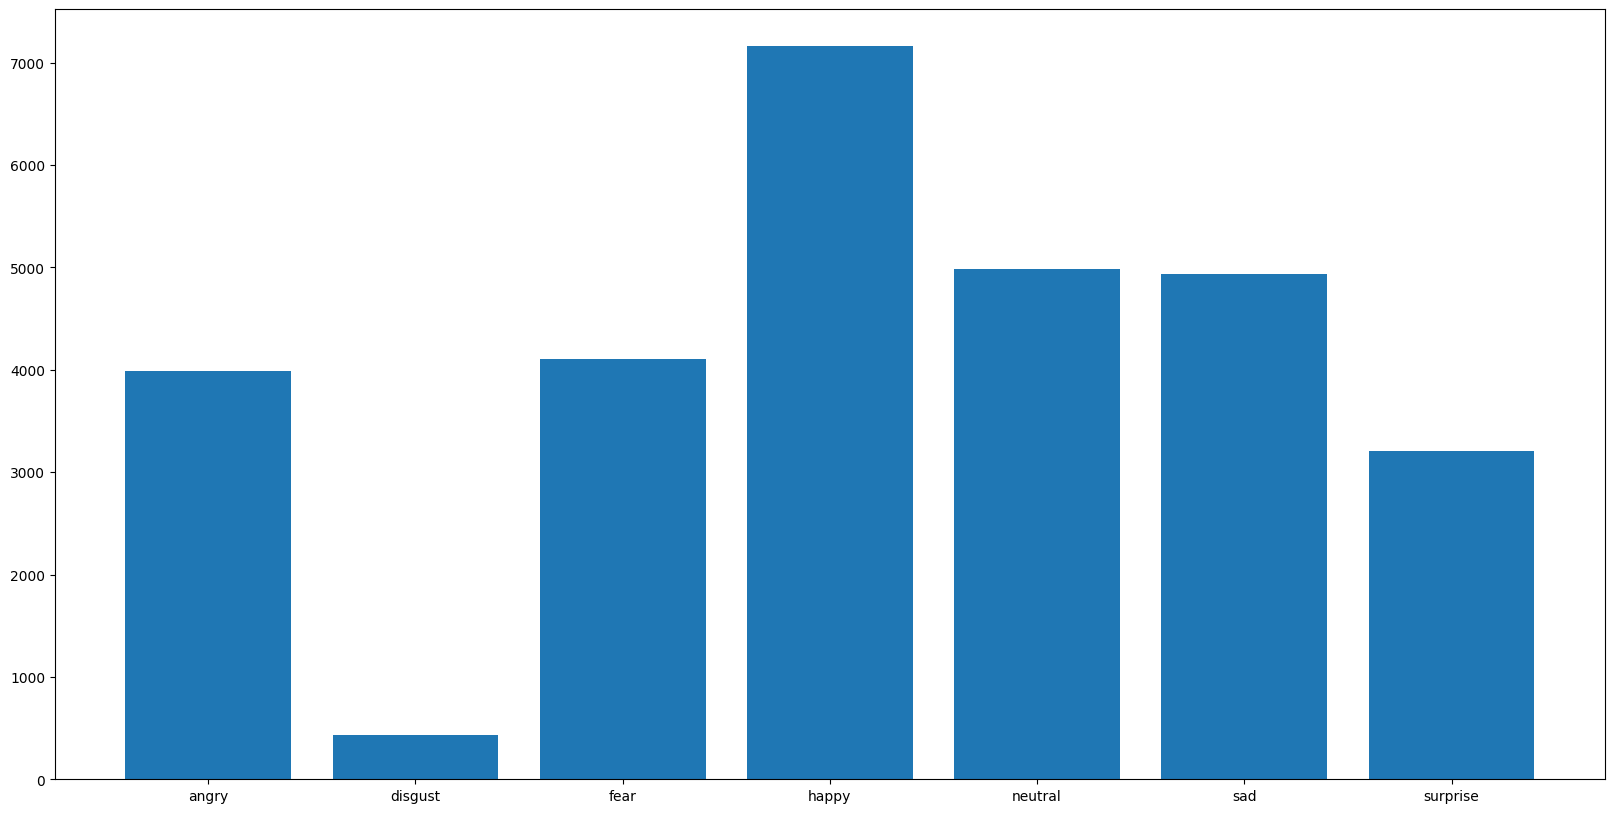

In [10]:
# Show class distribution
plt.figure(figsize=(20,10))
plt.bar(labels, [len(sets) for sets in label_ranges_train])

# Train Random Images per Label

In [11]:
# display 4 random images for each label
def displayRandomImages(train_images):
    global labels, per_label_range_train
    fig, ax = plt.subplots(len(labels), 4, figsize=(10,10))
    fig.tight_layout()
    for i in range(7):
        l = random.sample(range(per_label_range_train[i][0],per_label_range_train[i][1]),4)
        for j in range(4):
            ax[i][j].imshow(train_images[l[j]])
            ax[i][j].set_title(train_labels[l[j]])
            ax[i][j].axis('off')
    plt.show()

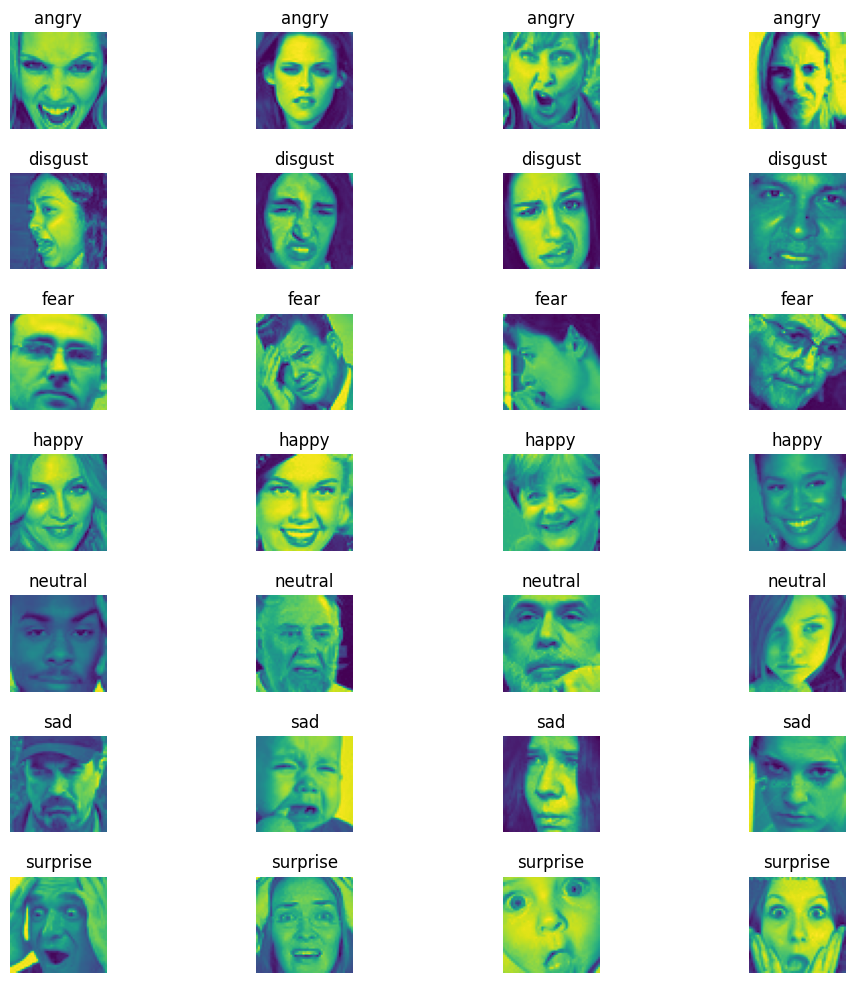

In [12]:
displayRandomImages(train_images)

In [13]:
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator

for curLabel in labels:
    if curLabel == "happy":
        continue
    else:
        minority_class_images_start = 0
        minority_class_images_end = 0
        majority_class_images_start = 0
        majority_class_images_end = 0
        for i,rangeSet in enumerate(per_label_range_train):
            min,max,label,count = rangeSet
            if label == curLabel:
                print(rangeSet)
                minority_class_images_start = min
                minority_class_images_end = max
            elif label == "happy":
                majority_class_images_start = min
                majority_class_images_end = max

        minority_class_images = train_images[minority_class_images_start:minority_class_images_end+1]
        majority_class_images = train_images[majority_class_images_start:majority_class_images_end+1]

        print("Number of majority class images: ",len(majority_class_images))
        print("Number of minority class images: ",len(minority_class_images))

        oversampled_minority_class_images = resample(minority_class_images,
                                                    replace=True,
                                                    n_samples=len(majority_class_images),
                                                    random_state=42)
        
        # Define an ImageDataGenerator for augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,      # Randomly rotate images by up to 10 degrees
            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
            height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
            zoom_range=0.1,         # Randomly zoom in by up to 10%
            horizontal_flip=True,   # Randomly flip images horizontally
            fill_mode='nearest'     # Fill in missing pixels with the nearest available pixel
        )

        # Generate augmented images for the oversampled minority class
        augmented_minority_images = []

        for images in oversampled_minority_class_images:
            
            for batch in datagen.flow(np.reshape(images, (1, images.shape[0], images.shape[1], 1)), batch_size=1):
                augmented_minority_images.append(batch[0])
                break
        # reshape the augmented images
        shuffled_indexes = np.arange(len(augmented_minority_images))
        np.random.shuffle(shuffled_indexes)
        augmented_minority_images = np.array(augmented_minority_images)[shuffled_indexes]
        augmented_minority_images = [np.reshape(image, (image.shape[0], image.shape[1])) for image in augmented_minority_images]
            
        for i in range(minority_class_images_start,minority_class_images_end+1):
            del train_images[i]
            del train_labels[i]
            
        train_images = train_images + augmented_minority_images
        train_labels = train_labels + [curLabel]*len(oversampled_minority_class_images)


(0, 3992, 'angry', 3993)
Number of majority class images:  7164
Number of minority class images:  3993
(13078, 13513, 'disgust', 436)
Number of majority class images:  7164
Number of minority class images:  436
(8975, 13077, 'fear', 4103)
Number of majority class images:  7164
Number of minority class images:  4103
(3993, 8974, 'neutral', 4982)
Number of majority class images:  7164
Number of minority class images:  4982
(23883, 28820, 'sad', 4938)
Number of majority class images:  7164
Number of minority class images:  4938
(20678, 23882, 'surprise', 3205)
Number of majority class images:  7164
Number of minority class images:  3205


In [14]:
print("Number of train images",len(train_images))
print("Number of train labels",len(train_labels))

Number of train images 50148
Number of train labels 50148


# Perform Label Encoding

In [15]:
# label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(len(train_labels_encoded))
print(len(train_labels))

test_labels_encoded = le.transform(test_labels)
print(len(test_labels_encoded))
print(len(test_labels_encoded))


50148
50148
7066
7066


# Constructing CNN

In [16]:
train_images = np.array(train_images)
train_labels_encoded = np.array(train_labels_encoded)

train_images = train_images.reshape(-1,48,48,1)

print(train_images.shape)
print(train_labels_encoded.shape)

(50148, 48, 48, 1)
(50148,)


In [17]:
# define model
def defineModel():
    global labels
    model = None
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
    model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model
    
    

In [18]:
model = defineModel()
with tf.device('/GPU:0'):
    history = model.fit(train_images,train_labels_encoded,epochs=20,batch_size=32,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 23, 23, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0

2023-10-21 19:53:29.174185: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-21 19:53:29.382709: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-21 19:53:30.294444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-21 19:53:31.577192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-21 19:53:34.315285: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3e08dbd830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-21 19:53:34.315348: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GP

1254/1254 [==============================] - 22s 12ms/step - loss: 1.9046 - accuracy: 0.2672 - val_loss: 2.3717 - val_accuracy: 0.0906
Epoch 2/20
1254/1254 [==============================] - 15s 12ms/step - loss: 1.6255 - accuracy: 0.3556 - val_loss: 2.9285 - val_accuracy: 0.2362
Epoch 3/20
1254/1254 [==============================] - 15s 12ms/step - loss: 1.5039 - accuracy: 0.3998 - val_loss: 3.4138 - val_accuracy: 0.2556
Epoch 4/20
1254/1254 [==============================] - 14s 12ms/step - loss: 1.4146 - accuracy: 0.4427 - val_loss: 4.0540 - val_accuracy: 0.2595
Epoch 5/20
1254/1254 [==============================] - 15s 12ms/step - loss: 1.3402 - accuracy: 0.4759 - val_loss: 5.8211 - val_accuracy: 0.2852
Epoch 6/20
1254/1254 [==============================] - 15s 12ms/step - loss: 1.2778 - accuracy: 0.5064 - val_loss: 4.1291 - val_accuracy: 0.2455
Epoch 7/20
1254/1254 [==============================] - 14s 11ms/step - loss: 1.2210 - accuracy: 0.5292 - val_loss: 4.3728 - val_accura

In [19]:
test_images = np.array(test_images).reshape(-1,48,48,1)
loss,accuracy = model.evaluate(test_images,test_labels_encoded)
print(f"Accuracy: {accuracy*100} Loss: {loss}")

221/221 [==============================] - 1s 5ms/step - loss: 1.7904 - accuracy: 0.4481
Accuracy: 44.806113839149475 Loss: 1.7904223203659058


In [20]:
# print evaliation metrics such as f1 score, accracy, precision and recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
print(classification_report(test_labels_encoded,predictions,labels=[0,1,2,3,4,5,6],target_names=labels))
print(confusion_matrix(test_labels_encoded,predictions))


221/221 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       angry       0.38      0.45      0.41       960
     disgust       0.10      0.09      0.09       111
        fear       0.26      0.22      0.24      1018
       happy       0.82      0.47      0.60      1825
     neutral       0.38      0.46      0.42      1216
         sad       0.33      0.48      0.40      1139
    surprise       0.68      0.67      0.67       797

    accuracy                           0.45      7066
   macro avg       0.42      0.41      0.40      7066
weighted avg       0.50      0.45      0.46      7066

[[430   3  84  46 164 201  32]
 [ 41  10  17   5  14  20   4]
 [167   4 221  25 235 262 104]
 [127  67 302 857 173 236  63]
 [161   7  63  61 563 326  35]
 [180   8 112  33 241 552  13]
 [ 40   3  61  19  88  53 533]]
